In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# kernel_sizes = (15,15)
kernel_sizes = (0,0)
ksize = kernel_sizes[0] if kernel_sizes[0]!=0 else -1
# Create a 64x64 sample image
image = np.zeros((64, 64, 3), dtype=np.uint8)
image[:, :32] = [0, 0, 0]
image[:, 32:] = [255, 255, 255]
cv2.imwrite('split_image.png', image)
# image = cv2.imread('split_image.png', cv2.IMREAD_GRAYSCALE)

# image = cv2.imread('mandrill.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


image = cv2.imread('peppers.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

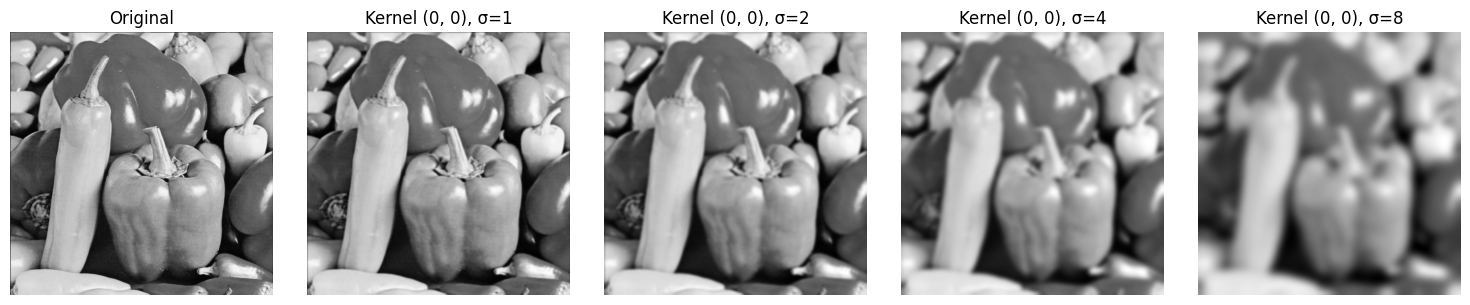

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def visualize_gaussian_filters(image):
    sigmas = [1, 2, 4, 8]
    
    plt.figure(figsize=(15, 3))
    
    # Original image
    plt.subplot(151)
    plt.title('Original')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    for j, sigma in enumerate(sigmas):
        
        # Apply Gaussian filter
        filtered = cv2.GaussianBlur(image, kernel_sizes, sigmaX=sigma, sigmaY=sigma)
        
        # Plot
        plt.subplot(1, len(sigmas)+1,  j + 2)
        plt.title(f'Kernel {kernel_sizes}, σ={sigma}')
        plt.imshow(filtered, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
# Run the visualization
visualize_gaussian_filters(image)

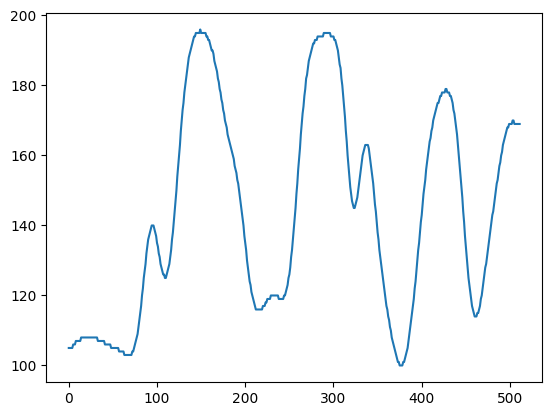

In [14]:
sig= 8
plt.plot(cv2.GaussianBlur(image, kernel_sizes, sigmaX=sig, sigmaY=sig)[0])


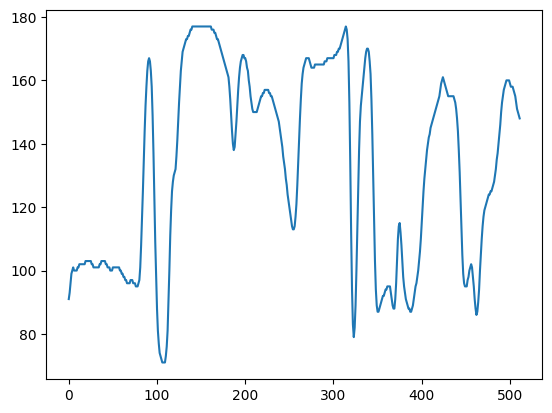

In [15]:
sig= 2
plt.plot(cv2.GaussianBlur(image, kernel_sizes, sigmaX=sig, sigmaY=sig)[0])


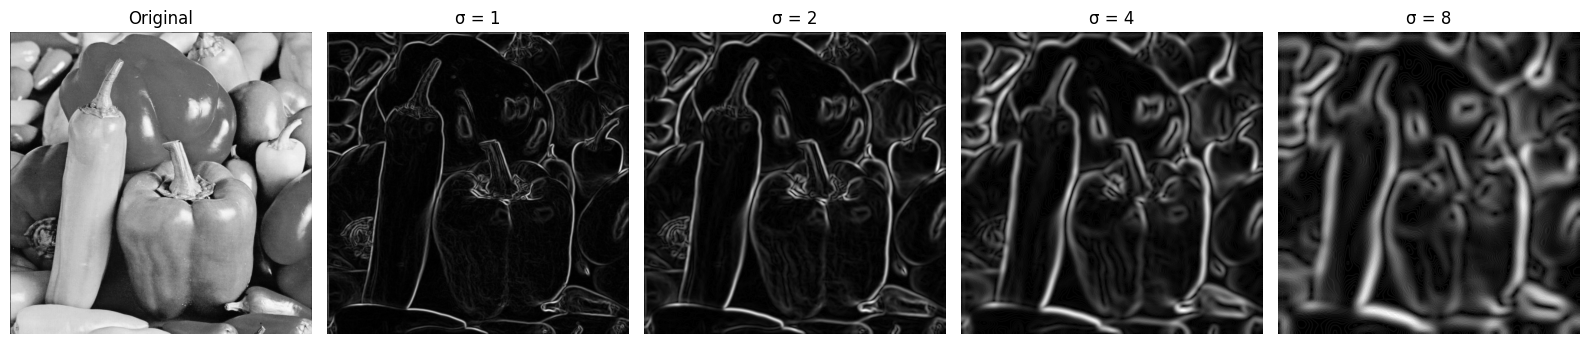

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_gradient_magnitude(image, sigma):
    # Convert image to grayscale if needed
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Compute Gaussian derivatives
    gradient_x = cv2.Sobel(gray.astype(np.float32), cv2.CV_32F, 1, 0, ksize=ksize, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    gradient_y = cv2.Sobel(gray.astype(np.float32), cv2.CV_32F, 0, 1, ksize=ksize, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    
    # Compute gradient magnitude
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    # Normalize for visualization
    gradient_magnitude = (gradient_magnitude - gradient_magnitude.min()) / (gradient_magnitude.max() - gradient_magnitude.min())
    
    return gradient_magnitude

def visualize_gradient_magnitudes(image):
    sigmas = [1, 2, 4, 8]
    
    plt.figure(figsize=(16, 8))
    
    # Original image
    plt.subplot(151)
    plt.title('Original')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    # Gradient magnitudes for different sigmas
    for i, sigma in enumerate(sigmas, 1):
        # Apply Gaussian blur with current sigma
        blurred = cv2.GaussianBlur(image, kernel_sizes, sigma,sigma)
        
        # Compute gradient magnitude
        grad_mag = compute_gradient_magnitude(blurred, sigma)
        
        plt.subplot(1, 5, i+1)
        plt.title(f'σ = {sigma}')
        plt.imshow(grad_mag, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
# Load an image first
visualize_gradient_magnitudes(image)

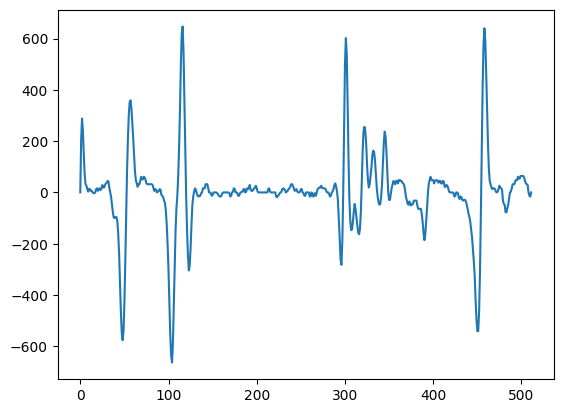

In [17]:
sig= 2
gauss = cv2.GaussianBlur(image, kernel_sizes, sigmaX=sig, sigmaY=sig)
gradient_x = cv2.Sobel(gauss.astype(np.float32), cv2.CV_32F, 1, 0, ksize=ksize, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
plt.plot(gradient_x[40])

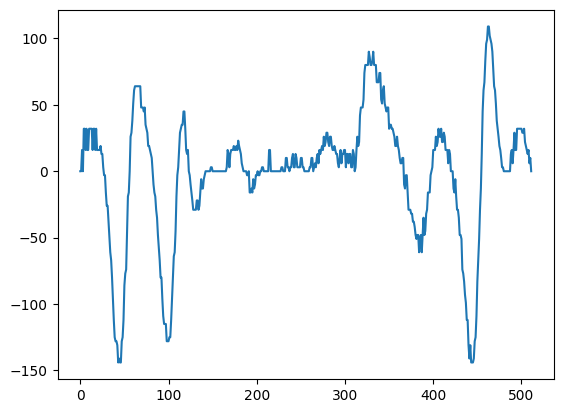

In [18]:
sig= 8
gauss = cv2.GaussianBlur(image, kernel_sizes, sigmaX=sig, sigmaY=sig)
# gradient_x = cv2.Sobel(gauss, cv2.CV_32F, 1, 0, ksize=ksize, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
gradient_x = cv2.Sobel(gauss.astype(np.float32), cv2.CV_32F, 1, 0, ksize=ksize, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)

plt.plot(gradient_x[40])

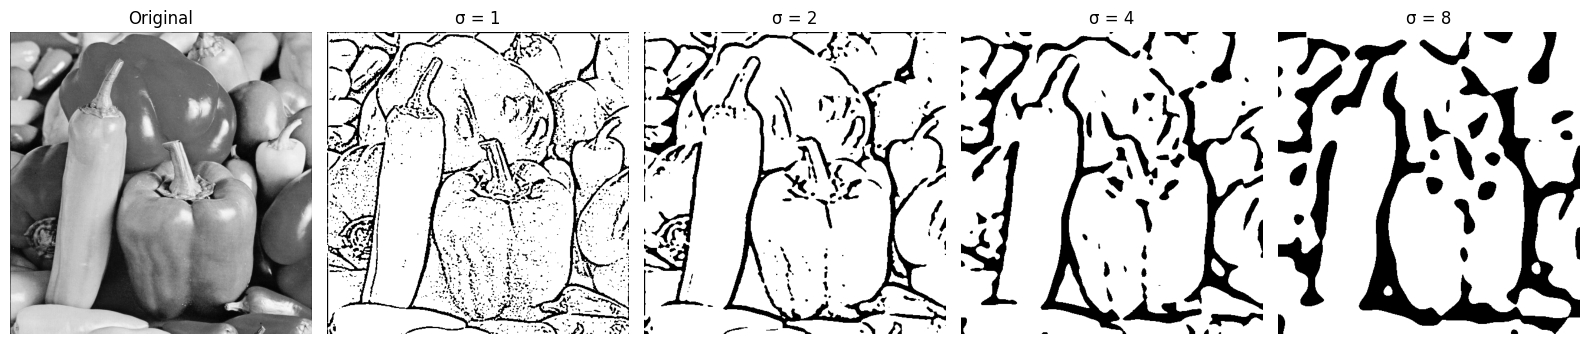

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def LoG_filter_opencv(image, sigma, size=None):
    # Generate LoG kernel
    if size is None:
        size = int(6 * sigma + 1) if sigma >= 1 else 7

    if size % 2 == 0:
        size += 1

    x, y = np.meshgrid(np.arange(-size//2+1, size//2+1), np.arange(-size//2+1, size//2+1))
    kernel = -(1/(np.pi * sigma**4)) * (1 - ((x**2 + y**2) / (2 * sigma**2))) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / np.sum(np.abs(kernel))

    # Perform convolution using OpenCV filter2D
    result = cv2.filter2D(image, -1, kernel)

    return result
# kernel_sizes = (15,15)
def laplacian_gaussian_filter(image, sigma):
    # Gaussian blurring
    gaussian1 = cv2.GaussianBlur(image, kernel_sizes, sigma, sigma)
    # gaussian2 = cv2.GaussianBlur(image, (15, 15), sigma * 2, sigma * 2)
    
    # dog = cv2.Laplacian(gaussian1, cv2.CV_32F,ksize=kernel_sizes[0])
    dog = LoG_filter_opencv(gaussian1, sigma)==0
    
    # # Difference of Gaussians (approximates Laplacian)
    # dog = gaussian1 - gaussian2
    
    # Normalize for visualization
    # dog_normalized = (dog - dog.min()) / (dog.max() - dog.min())
    
    return dog

def visualize_laplacian_gaussian(image):
    sigmas = [1, 2, 4, 8]
    
    plt.figure(figsize=(16, 4))
    
    # Original image
    plt.subplot(151)
    plt.title('Original')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    # Laplacian-Gaussian for different sigmas
    for i, sigma in enumerate(sigmas, 1):
        log_result = laplacian_gaussian_filter(image, sigma)
        
        plt.subplot(1, 5, i+1)
        plt.title(f'σ = {sigma}')
        plt.imshow(log_result, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
visualize_laplacian_gaussian(image)


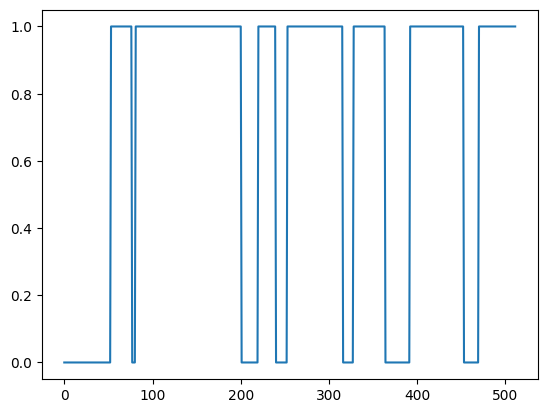

In [20]:
sigma = 8
gaussian1 = cv2.GaussianBlur(image, (15, 15), 0)
# dog = cv2.Laplacian(gaussian1, cv2.CV_32F,ksize=kernel_sizes[0])
# dog = cv2.Laplacian(gaussian1, cv2.CV_32F)
dog = LoG_filter_opencv(gaussian1, sigma)==0

# # Difference of Gaussians (approximates Laplacian)
# dog = gaussian1 - gaussian2
# dog_normalized = (dog - dog.min()) / (dog.max() - dog.min())

plt.plot(dog[10])


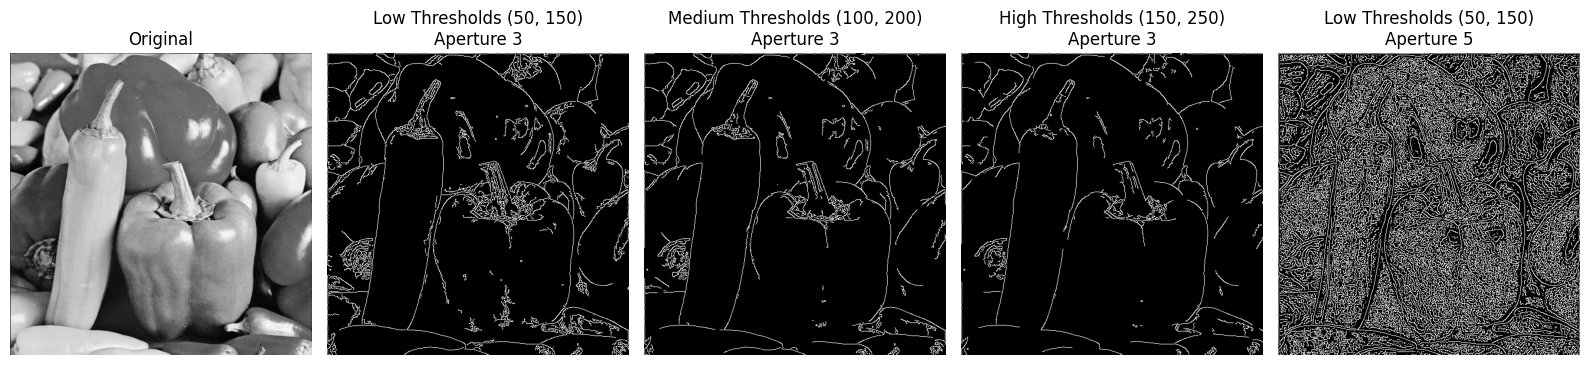

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def canny_edge_detection(image, low_threshold, high_threshold, aperture_size=3):
    """
    Perform Canny edge detection with configurable parameters
    
    Parameters:
    - low_threshold: Lower threshold for edge detection
    - high_threshold: Higher threshold for edge detection
    - aperture_size: Sobel operator size (3, 5, or 7)
    """
    edges = cv2.Canny(image, 
                      threshold1=low_threshold, 
                      threshold2=high_threshold, 
                      apertureSize=aperture_size)
    return edges

def visualize_canny_parameters(image):
    plt.figure(figsize=(16, 12))
    
    # Parameter combinations
    params = [
        (50, 150, 3),   # Low sensitivity
        (100, 200, 3),  # Medium sensitivity
        (150, 250, 3),  # High sensitivity
        (50, 150, 5),   # Larger aperture size
    ]
    
    titles = [
        'Low Thresholds (50, 150)\nAperture 3',
        'Medium Thresholds (100, 200)\nAperture 3', 
        'High Thresholds (150, 250)\nAperture 3',
        'Low Thresholds (50, 150)\nAperture 5'
    ]
    
    # Original image
    plt.subplot(1, 5, 1)
    plt.title('Original')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    # Canny edge detection with different parameters
    for i, (low, high, aperture) in enumerate(params, 2):
        edges = canny_edge_detection(image, low, high, aperture)
        
        plt.subplot(1, 5, i)
        plt.title(titles[i-2])
        plt.imshow(edges, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
visualize_canny_parameters(image)

# Explanation of Canny Edge Detection Parameters
# print("""
# Canny Edge Detection Parameters:

# 1. Low Threshold:
#    - Controls minimum edge intensity
#    - Lower values detect more edges (noisy)
#    - Higher values detect only strong edges

# 2. High Threshold:
#    - Defines strong edge intensity
#    - Determines which edges are definitely edges
#    - Higher values reduce edge detection sensitivity

# 3. Aperture Size:
#    - Sobel operator size for gradient computation
#    - Larger sizes (5, 7) reduce noise
#    - Smaller sizes (3) capture finer details
#    - Impacts edge detection precision

# Key Considerations:
# - Ratio between thresholds matters
# - Typical ratio: High threshold ≈ 2-3 × Low threshold
# - Adjust based on image complexity and noise
# """)

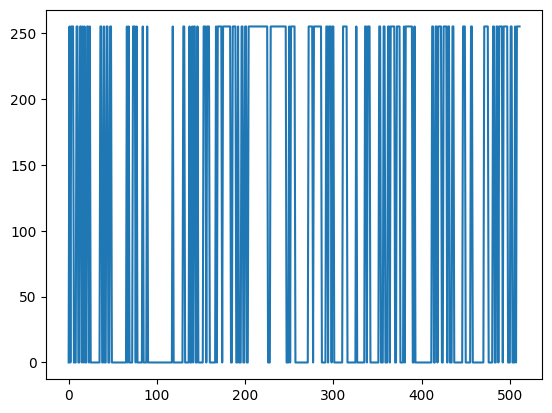

In [22]:
plt.plot(canny_edge_detection(image,50,150,3)[0])